### **Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Embeddings

Mounted at /content/drive
/content/drive/MyDrive/Embeddings


# **Importing All Libraries**

In [ ]:
import librosa, os, soundfile, numpy as np, pandas as pd, matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import StandardScaler, LabelEncoder
import glob, os
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import OneClassSVM
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import scipy.stats as stats
from sklearn.manifold import TSNE
import matplotlib

### **Loading Data**

In [ ]:
import glob
import numpy as np

totalLangData = [] #variable for all the 10 languages features
totalLabelData = [] #variable for all the labels

# Get all .npy files
npy_files = glob.glob("*.npy")

# Select the files you want to process using a list of indices
indices = [1,2,6,9,10,12,13,14,15,17]
for index in indices:
    if index < len(npy_files):
        filename = npy_files[index]
        oneLangData = np.load(filename, allow_pickle=True)
        langTrainData = oneLangData[0:4999, 4]
        totalLangData += [x.flatten().tolist() for x in langTrainData]
        label = oneLangData[0:4999, 1].tolist()
        totalLabelData += label

#convert both lists to numpy array to feed to the classifier
totalLangDataAsArray = np.asarray(totalLangData)
totalLabelDataAsArray = np.asarray(totalLabelData)

#data scaling
scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = totalLangDataAsArray
features_scaled = scaler.fit_transform(features_scaled)

#dimensionality reduction
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=69)
# Fit and transform the scaled features
components_tsnetrain = tsne.fit_transform(features_scaled)
kl_divergence = tsne.kl_divergence_
print("KL Divergence:", kl_divergence)



#data splitting
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    components_tsnetrain,
    totalLabelDataAsArray,
    test_size=0.3,
    random_state=69
)

KL Divergence: 1.6578925848007202


In [ ]:
#plotting
fig = px.scatter(components_tsnetrain, x=0, y=1,title=f'Total KL Divergence: {kl_divergence:.2f}%', color=totalLabelDataAsArray, labels={'0': 't-SNE Component 1', '1': 't-SNE Component 2'})
fig.update_layout(legend_title_text='Language')
fig.show()

In [ ]:
# Range of n_components to test
n_components_range = range(1, 11)  # Test from 1 to 10 components
kl_divergences = []

for n_components in n_components_range:
    tsne = TSNE(n_components=n_components, random_state=69)
    tsne.fit(features_scaled)  # Assuming 'features_scaled' is defined
    kl_divergences.append(tsne.kl_divergence_)

# Plot KL divergence vs. number of components
plt.plot(n_components_range, kl_divergences, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('KL Divergence')
plt.title('KL Divergence vs. Number of Components')
plt.grid(True)
plt.show()

### **Training OC-SVM**

In [ ]:
X = X_train_scaled
clf = OneClassSVM(nu=0.01, kernel ='rbf', gamma='auto').fit(X)

outliers_train = clf.predict(X)
outliers = np.count_nonzero(outliers_train==-1)
inliers = np.count_nonzero(outliers_train==1)
print("Training Data")
print("Outliers:",outliers)
print( "Inliers:",inliers)

#src = (clf.score_samples(X))
#finding labels
# The following line is changed to index into X instead of outliers_train
outlier_indices = np.where(clf.predict(X) == -1)[0]
outlier_labels = y_train_scaled[outlier_indices]
#print(f"Outlier Labels: {outlier_labels}")
label_counts = Counter(outlier_labels)
df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
print(df)


#testing
outliers_test = clf.predict(X_test_scaled)
outliers = np.count_nonzero(outliers_test==-1)
inliers = np.count_nonzero(outliers_test==1)
print("\n\n")
print("Testing Data")
print("Outliers:",outliers)
print( "Inliers:",inliers)

#src = (clf.score_samples(X))
#finding labels
# The following line is changed to index into X_test_scaled instead of outliers_test
outlier_indices = np.where(clf.predict(X_test_scaled) == -1)[0]
outlier_labels = y_test_scaled[outlier_indices]
#print(f"Outlier Labels: {outlier_labels}")
label_counts = Counter(outlier_labels)
df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
print(df)

Training Data
Outliers: 6249
Inliers: 28744
             Count
ne-Nepali      528
ur-Urdu        582
hi-Hindi       724
bn-Bengali     544
ta-Tamil       512
sd-Sindhi      790
as-Assamese    891
pa-Panjabi     530
te-Telugu      634
si-Sinhala     514



Testing Data
Outliers: 4015
Inliers: 10982
             Count
ne-Nepali      357
te-Telugu      361
sd-Sindhi      460
as-Assamese    497
ta-Tamil       359
pa-Panjabi     335
si-Sinhala     387
ur-Urdu        389
bn-Bengali     412
hi-Hindi       458


In [ ]:
# Separate inliers and outliers for plotting
inlier_indices = np.where(outliers_train == 1)[0]
outlier_indices = np.where(outliers_train == -1)[0]

# Count inliers and outliers
num_inliers = len(inlier_indices)
num_outliers = len(outlier_indices)


# Create DataFrame for plotting
df_plot = pd.DataFrame(X, columns=['t-SNE1', 't-SNE2'])
df_plot['Inliers'] = outliers_train == 1  # Mark outliers as False

# Plot inliers and outliers
fig = px.scatter(df_plot, x='t-SNE1', y='t-SNE2', color='Inliers',
                 title='One-Class SVM Outlier Detection',
                 labels={'t-SNE1': 't-SNE Component 1', 't-SNE2': 't-SNE Component 2'})

# Add legend with counts
fig.update_layout(legend_title_text=f'Inliers: {num_inliers}, Outliers: {num_outliers} (Red)')
fig.show()

### **Training N-SVM**

In [ ]:


# Train multi-class SVM with probability estimation
svm_model = SVC(kernel='rbf', probability=True)  # Choose an appropriate kernel
svm_model.fit(X_train_scaled, y_train_scaled)

# Predict class probabilities
class_probabilities = svm_model.predict_proba(X_test_scaled)

# Get unique class labels
class_labels = np.unique(y_test_scaled)

# Print probabilities with labels
for i, probs in enumerate(class_probabilities):
    print(f"Instance {i+1}:")
    for j, prob in enumerate(probs):
        print(f"  Class {class_labels[j]}: {prob:.4f}")

Streaming output truncated to the last 5000 lines.
  Class pa-Panjabi: 0.3981
  Class sd-Sindhi: 0.0208
  Class si-Sinhala: 0.0005
  Class ta-Tamil: 0.0003
  Class te-Telugu: 0.0006
  Class ur-Urdu: 0.4986
Instance 14544:
  Class as-Assamese: 0.0001
  Class bn-Bengali: 0.0000
  Class hi-Hindi: 0.0258
  Class ne-Nepali: 0.0000
  Class pa-Panjabi: 0.8968
  Class sd-Sindhi: 0.0004
  Class si-Sinhala: 0.0001
  Class ta-Tamil: 0.0000
  Class te-Telugu: 0.0001
  Class ur-Urdu: 0.0766
Instance 14545:
  Class as-Assamese: 0.0239
  Class bn-Bengali: 0.0235
  Class hi-Hindi: 0.0219
  Class ne-Nepali: 0.6370
  Class pa-Panjabi: 0.0088
  Class sd-Sindhi: 0.1024
  Class si-Sinhala: 0.0791
  Class ta-Tamil: 0.0324
  Class te-Telugu: 0.0176
  Class ur-Urdu: 0.0534
Instance 14546:
  Class as-Assamese: 0.9998
  Class bn-Bengali: 0.0000
  Class hi-Hindi: 0.0000
  Class ne-Nepali: 0.0000
  Class pa-Panjabi: 0.0000
  Class sd-Sindhi: 0.0000
  Class si-Sinhala: 0.0000
  Class ta-Tamil: 0.0002
  Class te-Te

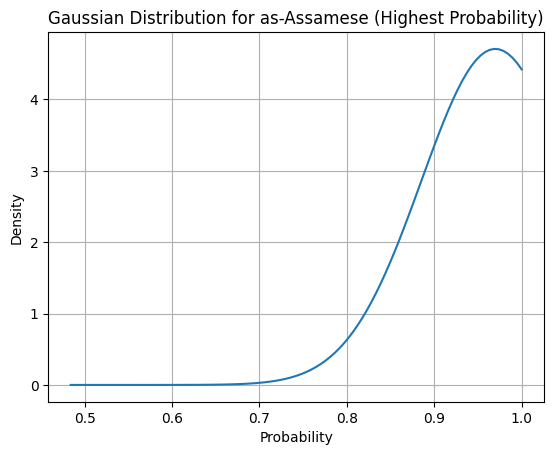

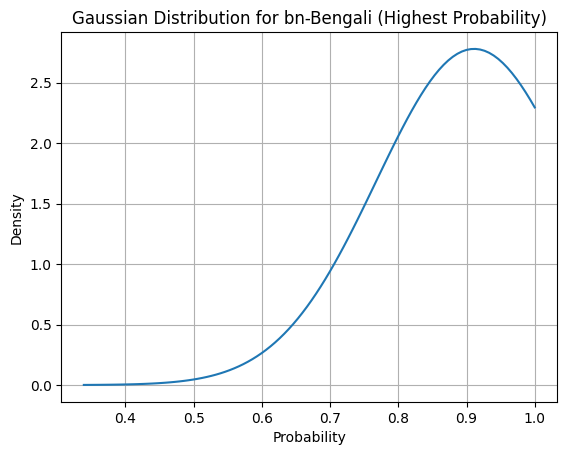

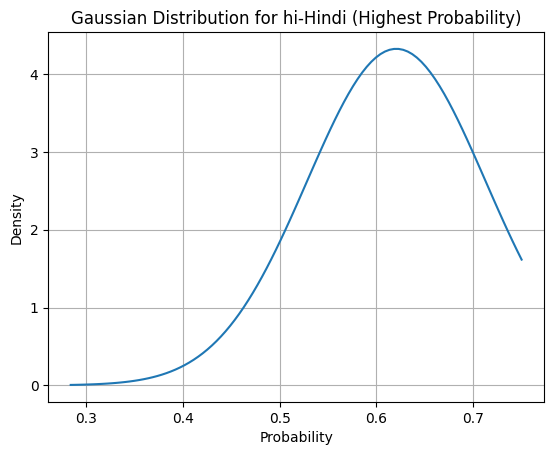

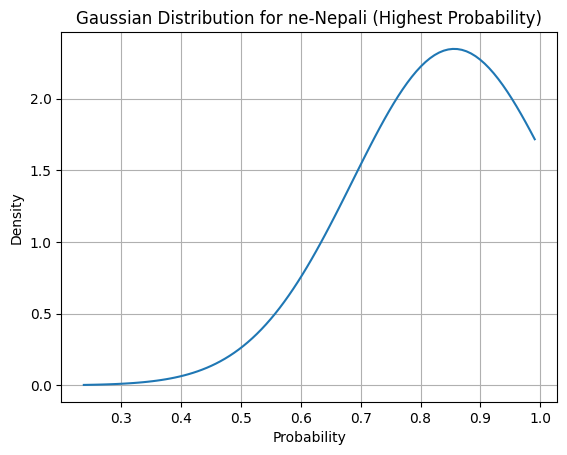

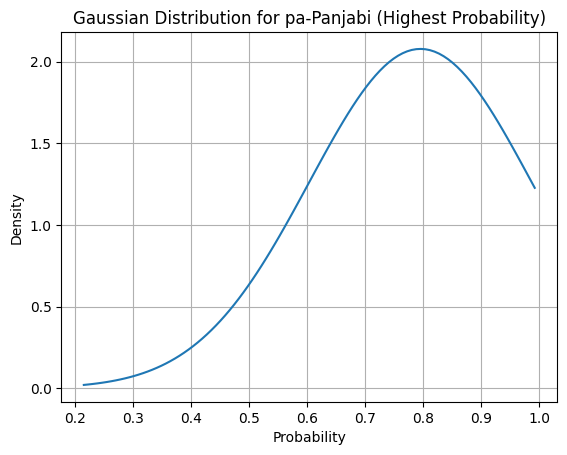

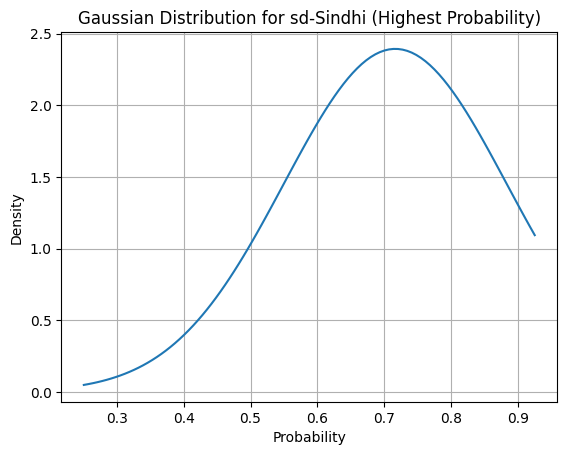

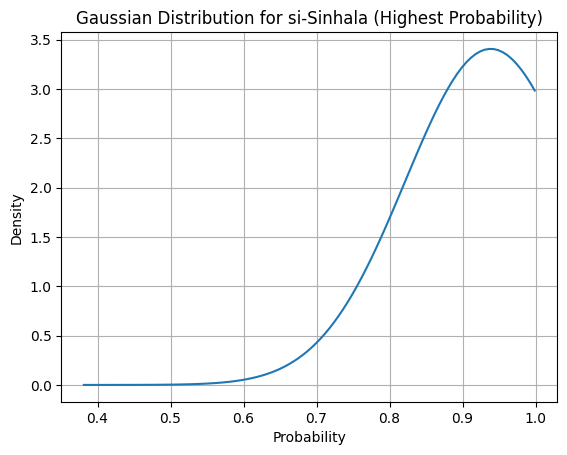

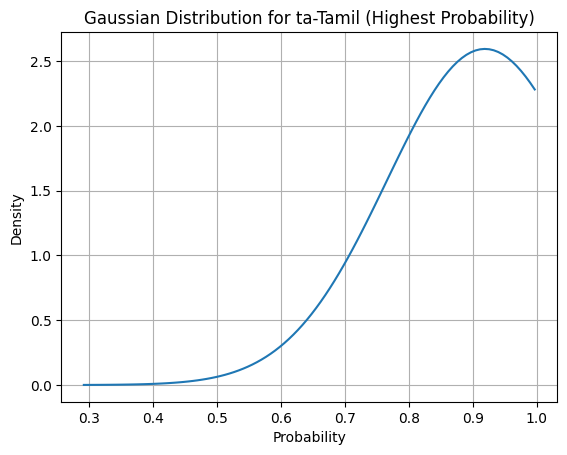

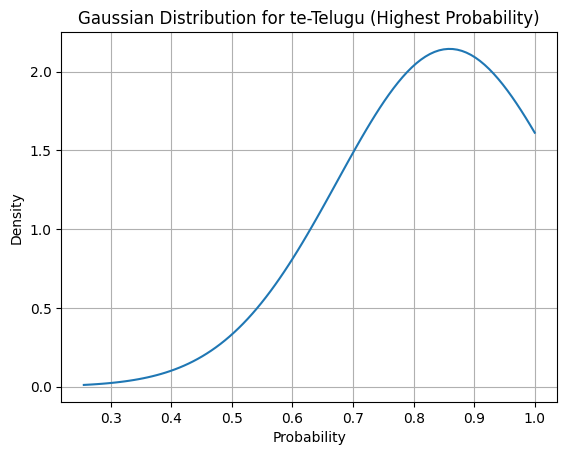

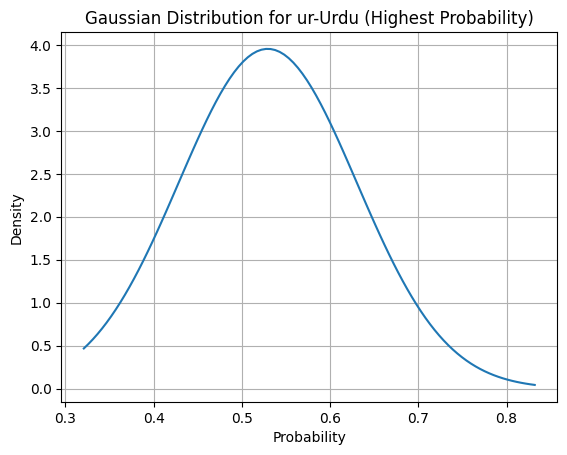

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# ... (Previous code for collecting probabilities and instances)

# Plot Gaussian distribution for each class separately
for label, data in class_data.items():
    probs = np.array(data['probs'])  # Convert list to NumPy array for norm.fit()

    # Fit a Gaussian distribution to the probabilities
    mu, std = norm.fit(probs)

    # Generate x-values for the Gaussian curve
    x = np.linspace(probs.min(), probs.max(), 100)

    # Calculate the corresponding y-values (PDF)
    y = norm.pdf(x, mu, std)

    plt.figure()
    plt.plot(x, y)
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.title(f'Gaussian Distribution for {label} (Highest Probability)')
    plt.grid(True)
    plt.show()


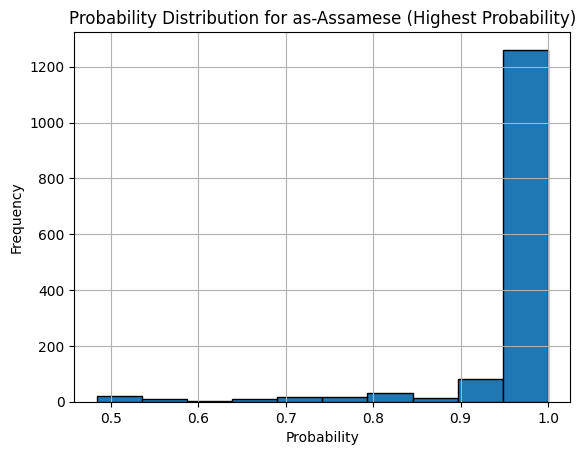

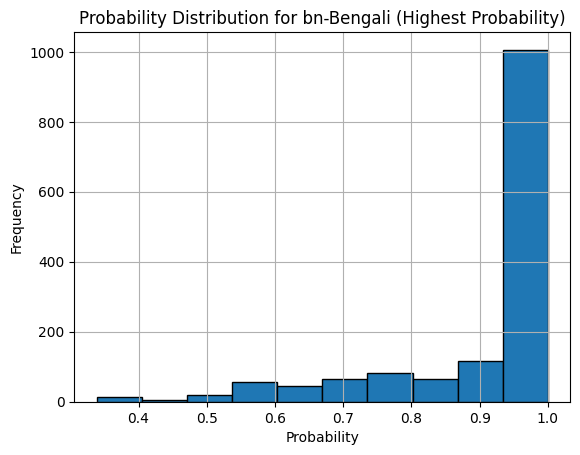

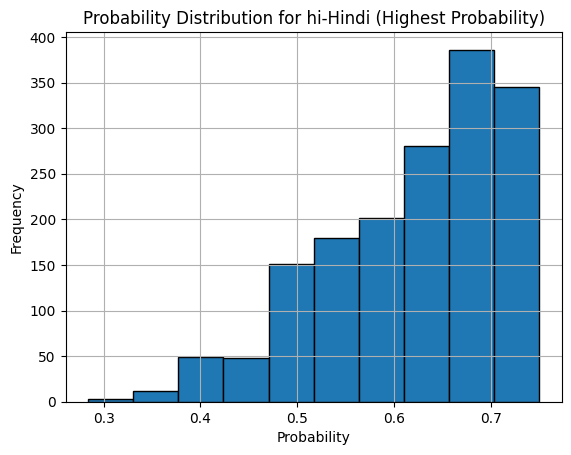

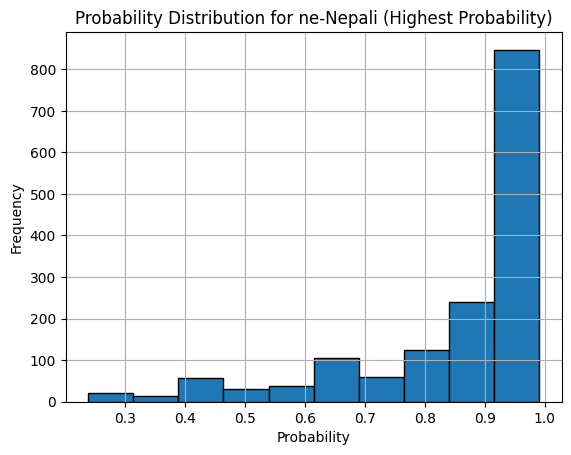

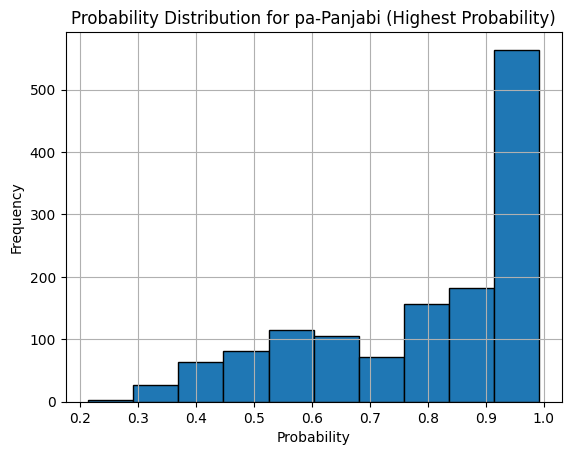

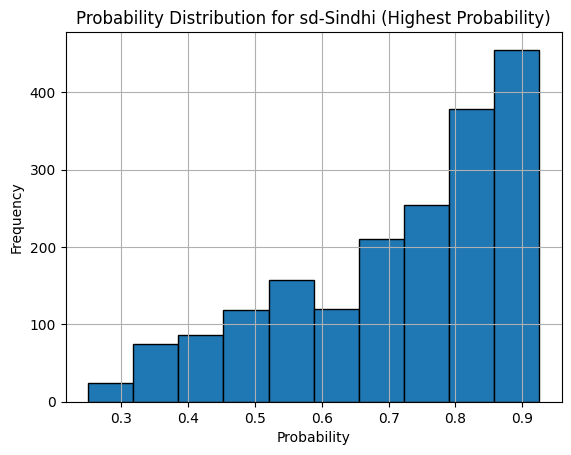

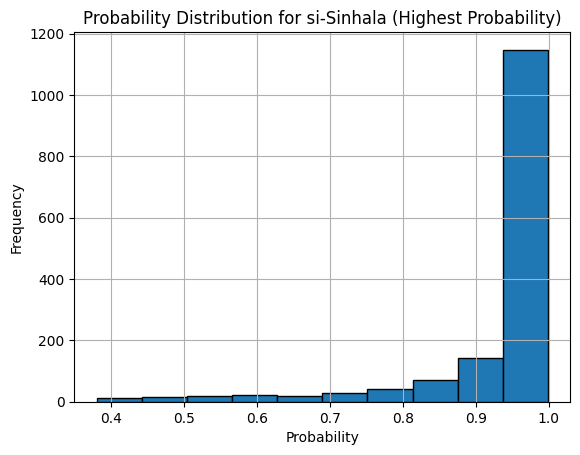

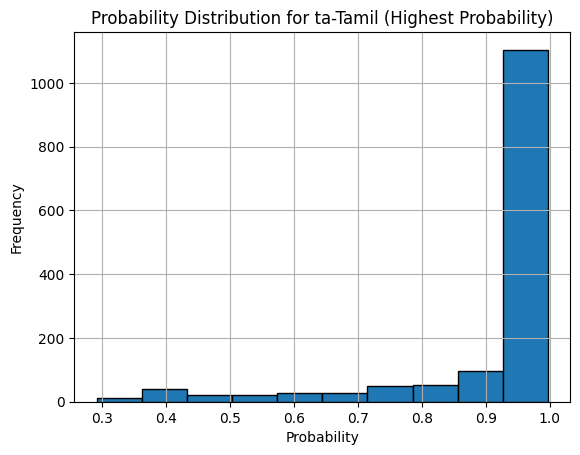

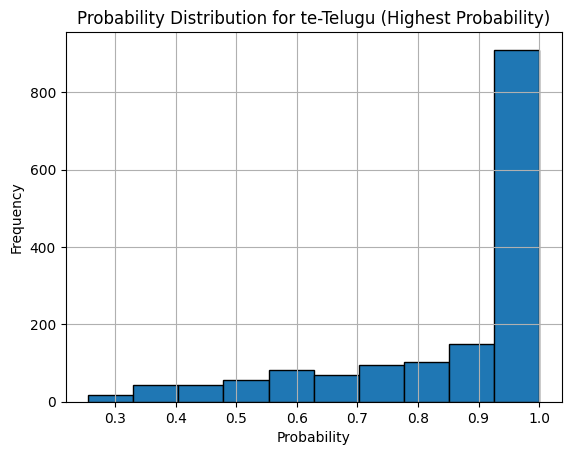

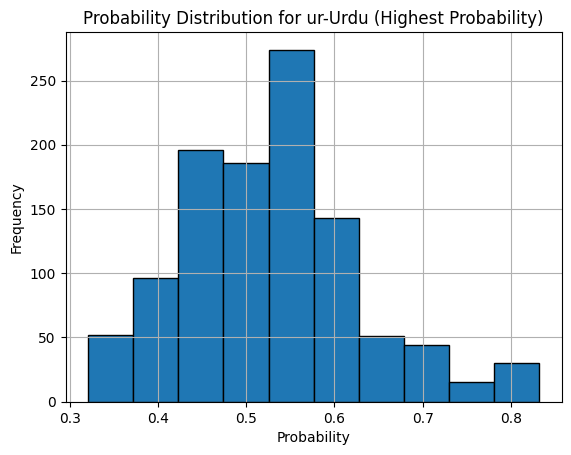

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for each class separately
for label, data in class_data.items():
    probs = data['probs']
    plt.figure()
    plt.hist(probs, bins=10, edgecolor='black')  # Adjust bins as needed
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title(f'Probability Distribution for {label} (Highest Probability)')
    plt.grid(True)
    plt.show()

In [ ]:
import numpy as np


# Get unique class labels
class_labels = np.unique(y_test_scaled)

# Create a dictionary to store highest probabilities for each class
highest_probs = {label: [] for label in class_labels}

# Append highest probabilities to corresponding classes
for probs in class_probabilities:
    highest_prob = np.max(probs)
    predicted_class_index = np.argmax(probs)
    predicted_class = class_labels[predicted_class_index]
    highest_probs[predicted_class].append(highest_prob)

# Calculate mean, standard deviation, and threshold for each class
for label, probs in highest_probs.items():
    probs_array = np.array(probs)
    mean_prob = np.mean(probs_array)
    std_dev = np.std(probs_array)
    threshold = mean_prob - std_dev
    print(f"Class {label}:")
    print(f"  Mean Probability: {mean_prob:.4f}")
    print(f"  Standard Deviation: {std_dev:.4f}")
    print(f"  Threshold (Mean - Std Dev): {threshold:.4f}")

Class as-Assamese:
  Mean Probability: 0.9698
  Standard Deviation: 0.0849
  Threshold (Mean - Std Dev): 0.8849
Class bn-Bengali:
  Mean Probability: 0.9108
  Standard Deviation: 0.1439
  Threshold (Mean - Std Dev): 0.7669
Class hi-Hindi:
  Mean Probability: 0.6270
  Standard Deviation: 0.0947
  Threshold (Mean - Std Dev): 0.5323
Class ne-Nepali:
  Mean Probability: 0.8554
  Standard Deviation: 0.1695
  Threshold (Mean - Std Dev): 0.6859
Class pa-Panjabi:
  Mean Probability: 0.7935
  Standard Deviation: 0.1932
  Threshold (Mean - Std Dev): 0.6003
Class sd-Sindhi:
  Mean Probability: 0.7158
  Standard Deviation: 0.1668
  Threshold (Mean - Std Dev): 0.5490
Class si-Sinhala:
  Mean Probability: 0.9389
  Standard Deviation: 0.1168
  Threshold (Mean - Std Dev): 0.8222
Class ta-Tamil:
  Mean Probability: 0.9194
  Standard Deviation: 0.1535
  Threshold (Mean - Std Dev): 0.7659
Class te-Telugu:
  Mean Probability: 0.8594
  Standard Deviation: 0.1858
  Threshold (Mean - Std Dev): 0.6736
Class u

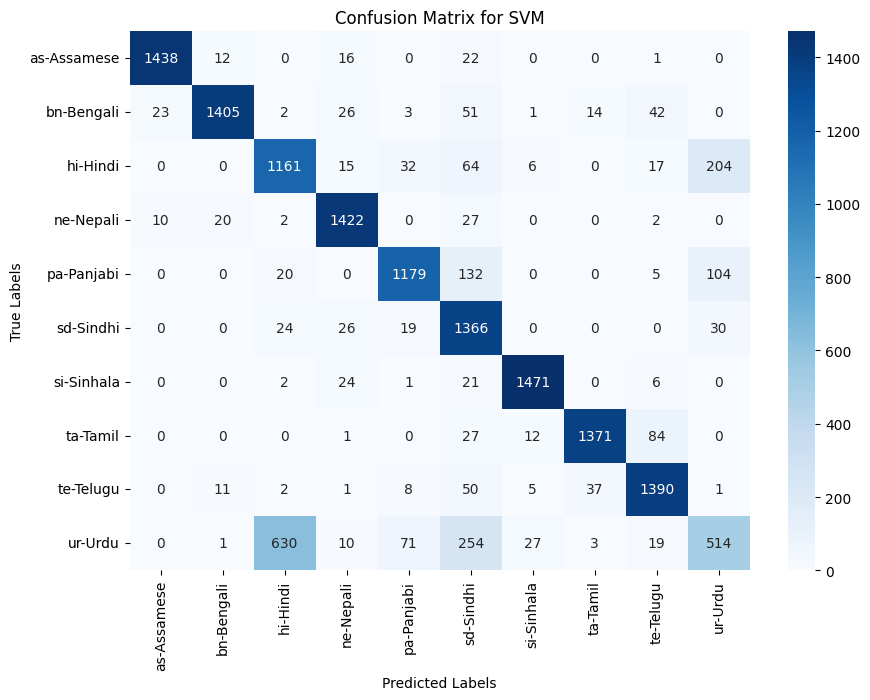

In [ ]:
# Train multi-class SVM with probability estimation
svm_model = SVC(kernel='rbf', probability=True)  # Choose an appropriate kernel
svm_model.fit(X_train_scaled, y_train_scaled)

# Predict classes using the trained SVM model
y_pred = svm_model.predict(X_test_scaled)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_scaled, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_scaled),
            yticklabels=np.unique(y_test_scaled))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM')
plt.show()

### **Testing SVM on OOS Data**

In [ ]:
testLangData = [] #variable for all the 5 languages features
testLabelData = [] #variable for all the labels

npy_files = glob.glob("*.npy")

# Select the files you want to process using a list of indices
indices = [0,3,4,5,7,8,11,16,18,19]
for index in indices:
    if index < len(npy_files):
        filename = npy_files[index]
        oneLangData = np.load(filename, allow_pickle=True)
        langTrainData = oneLangData[0:4999, 4]
        testLangData += [x.flatten().tolist() for x in langTrainData]
        label = oneLangData[0:4999, 1].tolist()
        testLabelData += label


#convert both lists to numpy array to feed to the classifier
testLangDataAsArray = np.asarray(testLangData)
testLabelDataAsArray = np.asarray(testLabelData)
print(testLangDataAsArray.shape)
print(testLabelDataAsArray.shape)

#data scaling
scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
featurestest_scaled = testLangDataAsArray
featurestest_scaled = scaler.fit_transform(featurestest_scaled)

#dimensionality reduction
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=69)
# Fit and transform the scaled features
components_tsnetest = tsne.fit_transform(features_scaled)
kl_divergence = tsne.kl_divergence_
print("KL Divergence:", kl_divergence)

#printing Standard sacled features
#print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
#features_scaled_df = pd.DataFrame(features_scaled)
#print(features_scaled_df)

#data splitting
X_Test, y_Test = components_tsnetest, testLabelDataAsArray

(49990, 256)
(49990,)
KL Divergence: 1.6578925848007202


In [ ]:
class_probabilities = svm_model.predict_proba(X_Test)

In [ ]:
# Get unique class labels
class_labels = np.unique(y_test_scaled)

# Create a dictionary to store highest probabilities for each class
highest_probs = {label: [] for label in class_labels}

# Append highest probabilities to corresponding classes
for probs in class_probabilities:
    highest_prob = np.max(probs)
    predicted_class_index = np.argmax(probs)
    predicted_class = class_labels[predicted_class_index]
    highest_probs[predicted_class].append(highest_prob)

# Calculate mean, standard deviation, and threshold for each class
thresholds = {}
for label, probs in highest_probs.items():
    probs_array = np.array(probs)
    mean_prob = np.mean(probs_array)
    std_dev = np.std(probs_array)
    threshold = mean_prob - std_dev
    thresholds[label] = threshold

# Iterate through instances and check against thresholds
for i, probs in enumerate(class_probabilities):
    highest_prob = np.max(probs)
    predicted_class_index = np.argmax(probs)
    predicted_class = class_labels[predicted_class_index]

    if highest_prob >= thresholds[predicted_class]:
        print(f"Instance {i+1}: Predicted Class - {predicted_class}")
    else:
        print(f"Instance {i+1}: Out of Set")

In [ ]:
0# Get unique class labels
class_labels = np.unique(y_test_scaled)

# Create a dictionary to store highest probabilities for each class
highest_probs = {label: [] for label in class_labels}

# Append highest probabilities to corresponding classes
for probs in class_probabilities:
    highest_prob = np.max(probs)
    predicted_class_index = np.argmax(probs)
    predicted_class = class_labels[predicted_class_index]
    highest_probs[predicted_class].append(highest_prob)

# Calculate mean, standard deviation, and threshold for each class
thresholds = {}
for label, probs in highest_probs.items():
    probs_array = np.array(probs)
    mean_prob = np.mean(probs_array)
    std_dev = np.std(probs_array)
    threshold = mean_prob - std_dev
    thresholds[label] = threshold

# Iterate through instances and check against thresholds
for i, (probs, true_label) in enumerate(zip(class_probabilities, y_Test)):
    highest_prob = np.max(probs)
    predicted_class_index = np.argmax(probs)
    predicted_class = class_labels[predicted_class_index]

    if highest_prob >= thresholds[predicted_class]:
        print(f"Instance {i+1}: True - {true_label}, Predicted - {predicted_class}")
    else:
        print(f"Instance {i+1}: True - {true_label}, Out of Set")

Streaming output truncated to the last 5000 lines.
Instance 44991: True - vi-Vietnamese, Predicted - te-Telugu
Instance 44992: True - zh-Mandarin, Predicted - ur-Urdu
Instance 44993: True - zh-Mandarin, Predicted - ur-Urdu
Instance 44994: True - zh-Mandarin, Predicted - ur-Urdu
Instance 44995: True - zh-Mandarin, Predicted - ur-Urdu
Instance 44996: True - zh-Mandarin, Predicted - ur-Urdu
Instance 44997: True - zh-Mandarin, Predicted - ur-Urdu
Instance 44998: True - zh-Mandarin, Predicted - ur-Urdu
Instance 44999: True - zh-Mandarin, Predicted - ur-Urdu
Instance 45000: True - zh-Mandarin, Predicted - ur-Urdu
Instance 45001: True - zh-Mandarin, Predicted - hi-Hindi
Instance 45002: True - zh-Mandarin, Out of Set
Instance 45003: True - zh-Mandarin, Predicted - ur-Urdu
Instance 45004: True - zh-Mandarin, Predicted - ur-Urdu
Instance 45005: True - zh-Mandarin, Predicted - ur-Urdu
Instance 45006: True - zh-Mandarin, Predicted - ur-Urdu
Instance 45007: True - zh-Mandarin, Predicted - ur-Urdu
I

In [ ]:
from collections import defaultdict

# ... (Previous code for calculating probabilities, thresholds, etc.)

# Initialize a dictionary to store counts
class_counts = defaultdict(lambda: {"Out of Set": 0, "Predicted": 0})

# Iterate through instances and check against thresholds
for i, (probs, true_label) in enumerate(zip(class_probabilities, y_Test)):
    highest_prob = np.max(probs)
    predicted_class_index = np.argmax(probs)
    predicted_class = class_labels[predicted_class_index]

    if highest_prob >= thresholds[predicted_class]:
        class_counts[true_label]["Predicted"] += 1
    else:
        class_counts[true_label]["Out of Set"] += 1

# Print results
for label, counts in class_counts.items():
    print(f"Class {label}:")
    print(f"  Out of Set: {counts['Out of Set']}")
    print(f"  Predicted: {counts['Predicted']}")

Class ar-Arabic:
  Out of Set: 460
  Predicted: 4539
Class bo-Tibetan:
  Out of Set: 997
  Predicted: 4002
Class en-English:
  Out of Set: 1004
  Predicted: 3995
Class fa-Persian:
  Out of Set: 614
  Predicted: 4385
Class id-Indonesian:
  Out of Set: 884
  Predicted: 4115
Class my-Burmese:
  Out of Set: 796
  Predicted: 4203
Class ps-Pushto:
  Out of Set: 584
  Predicted: 4415
Class th-Thai:
  Out of Set: 672
  Predicted: 4327
Class vi-Vietnamese:
  Out of Set: 664
  Predicted: 4335
Class zh-Mandarin:
  Out of Set: 1120
  Predicted: 3879


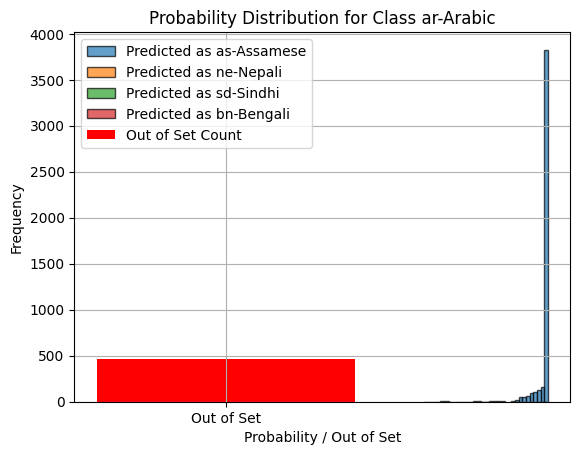

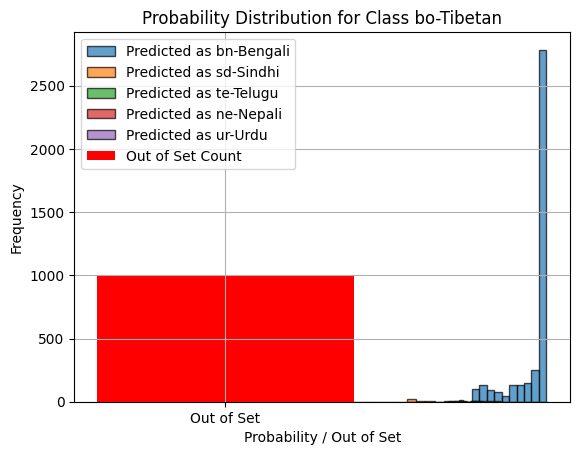

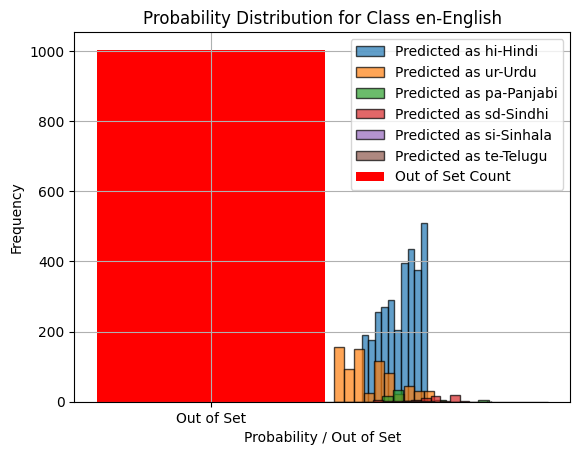

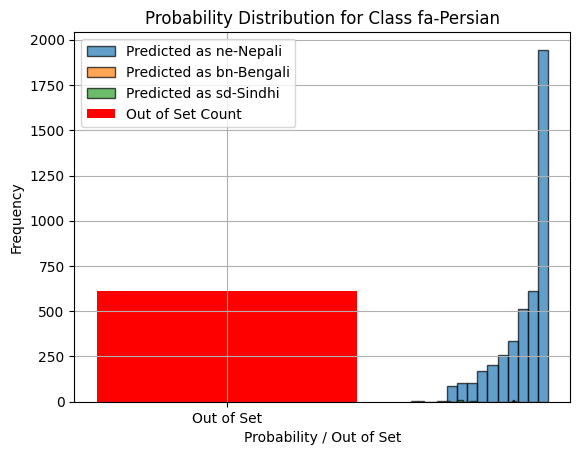

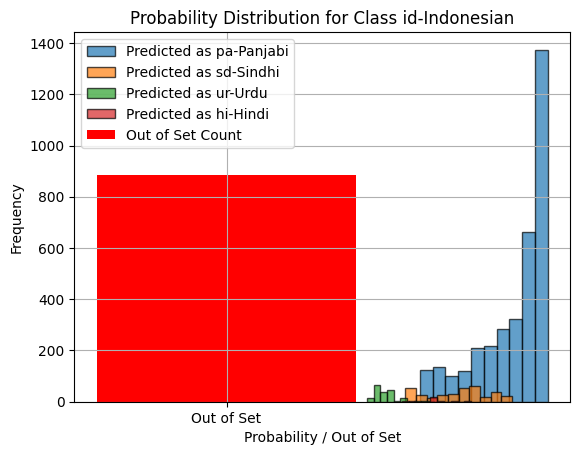

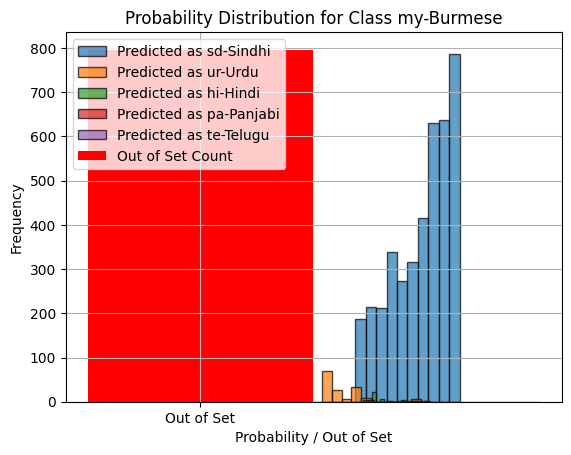

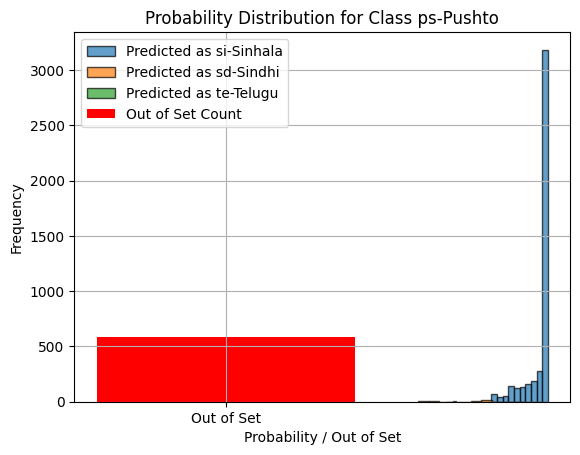

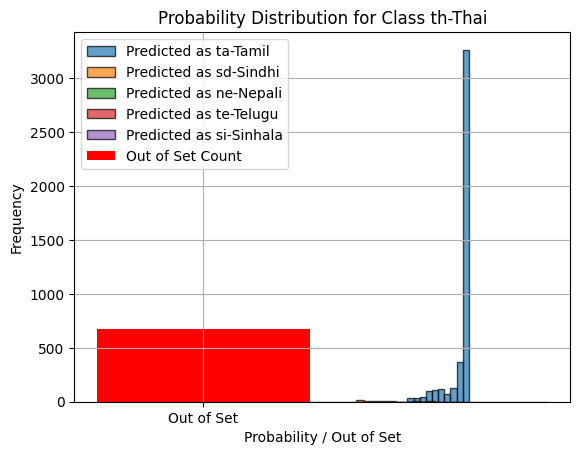

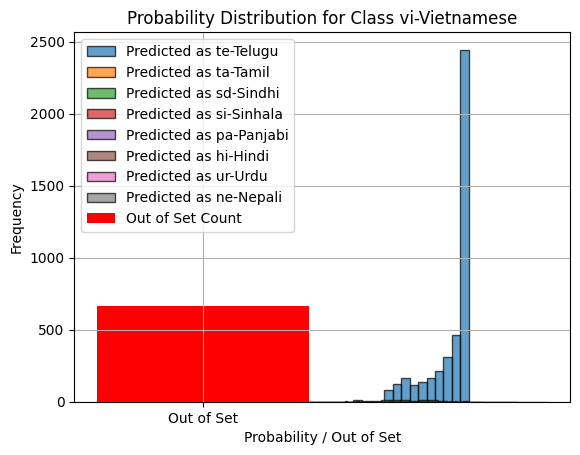

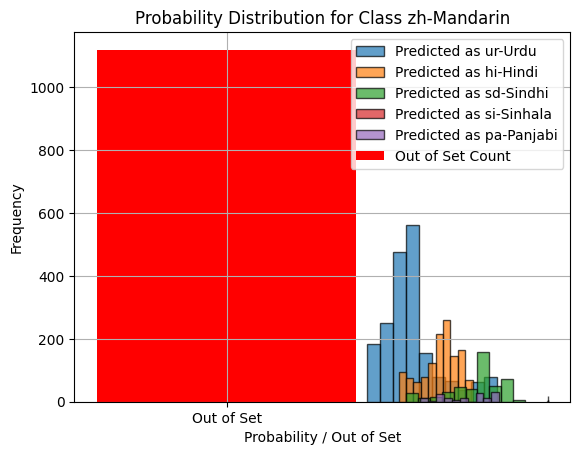

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

# ... (Previous code for calculating probabilities, thresholds, etc.)

# Iterate over each class label
for label in np.unique(y_Test):
    probabilities_in_class = defaultdict(list)
    out_of_set_count = 0

    # Filter instances for the current class and collect probabilities
    for i, (probs, true_label) in enumerate(zip(class_probabilities, y_Test)):
        if true_label == label:
            highest_prob = np.max(probs)
            predicted_class_index = np.argmax(probs)
            predicted_class = class_labels[predicted_class_index]

            if highest_prob >= thresholds[predicted_class]:
                probabilities_in_class[predicted_class].append(highest_prob)
            else:
                out_of_set_count += 1

    # Plot histogram for the current class
    plt.figure()
    for predicted_label, probs in probabilities_in_class.items():
        plt.hist(probs, bins=10, edgecolor='black', alpha=0.7, label=f"Predicted as {predicted_label}")
    plt.bar("Out of Set", out_of_set_count, color='red', label="Out of Set Count")

    plt.xlabel('Probability / Out of Set')
    plt.ylabel('Frequency')
    plt.title(f'Probability Distribution for Class {label}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# ... (Previous code for calculating probabilities, thresholds, etc.)

total_out_of_set = 0
total_instances = 0

# Iterate through instances and count "Out of Set" predictions
for i, (probs, true_label) in enumerate(zip(class_probabilities, y_Test)):
    highest_prob = np.max(probs)
    predicted_class_index = np.argmax(probs)
    predicted_class = class_labels[predicted_class_index]

    total_instances += 1
    if highest_prob < thresholds[predicted_class]:
        total_out_of_set += 1

# Calculate overall "Out of Set" percentage
out_of_set_percentage = (total_out_of_set / total_instances) * 100

# Print count and percentage of "Out of Set" predictions
print("Count of Out of Set Predictions:", total_out_of_set)
print(f"Overall Out of Set Percentage: {out_of_set_percentage:.2f}%")

Count of Out of Set Predictions: 7799
Overall Out of Set Percentage: 15.60%


In [ ]:
# ... (Previous code for calculating probabilities, thresholds, etc.)

# Initialize a dictionary to store counts
class_counts = defaultdict(lambda: {"Out of Set": 0, "Total": 0})

# Iterate through instances and update counts
for i, (probs, true_label) in enumerate(zip(class_probabilities, y_Test)):
    highest_prob = np.max(probs)
    predicted_class_index = np.argmax(probs)
    predicted_class = class_labels[predicted_class_index]

    class_counts[true_label]["Total"] += 1
    if highest_prob < thresholds[predicted_class]:
        class_counts[true_label]["Out of Set"] += 1

# Print out-of-set percentages for each class
for label, counts in class_counts.items():
    out_of_set_percentage = (counts["Out of Set"] / counts["Total"]) * 100
    print(f"Class {label}: Out of Set Percentage = {out_of_set_percentage:.2f}%")

Class ar-Arabic: Out of Set Percentage = 9.20%
Class bo-Tibetan: Out of Set Percentage = 19.94%
Class en-English: Out of Set Percentage = 20.08%
Class fa-Persian: Out of Set Percentage = 12.28%
Class id-Indonesian: Out of Set Percentage = 17.68%
Class my-Burmese: Out of Set Percentage = 15.92%
Class ps-Pushto: Out of Set Percentage = 11.68%
Class th-Thai: Out of Set Percentage = 13.44%
Class vi-Vietnamese: Out of Set Percentage = 13.28%
Class zh-Mandarin: Out of Set Percentage = 22.40%


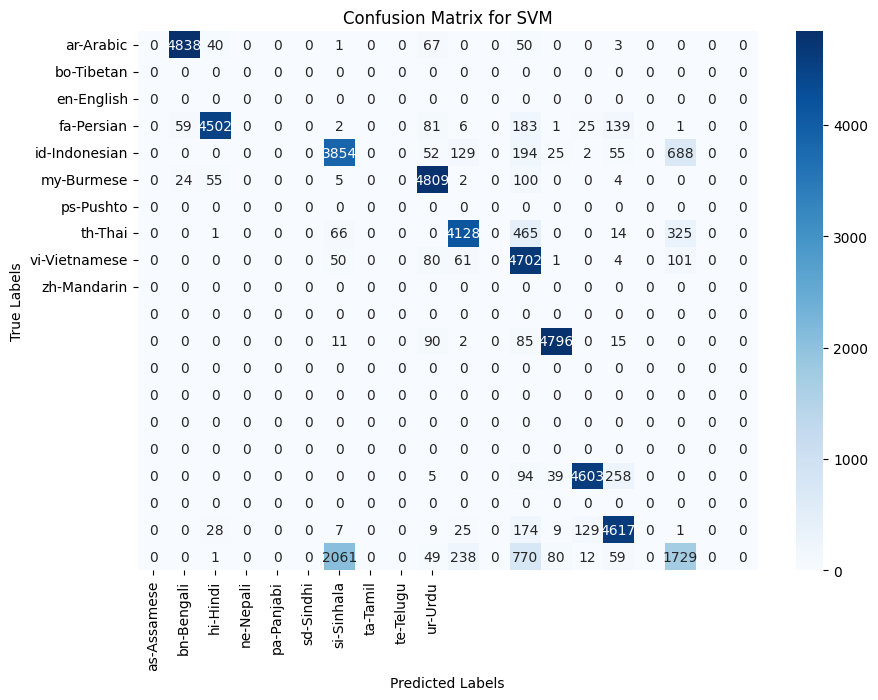

In [ ]:

# Predict classes using the trained SVM model
y_pred = svm_model.predict(X_Test)


# Calculate the confusion matrix
cm = confusion_matrix(y_Test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_scaled),
            yticklabels=np.unique(y_Test))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM')
plt.show()

In [ ]:
#clf is trained OC-SVM classifier
#languages taken: 8:Burmese, 11:pushto, 16:Thai, 18:Vietnamese, 19:Mandarian
Testing = clf.predict(X_Test) # Scaled features of testing data passing through trained c-svm
outliers = np.count_nonzero(Testing == -1)
inliers = np.count_nonzero(Testing == 1)
print("\n\n")
print("Testing Data")
print("Outliers:",outliers)
print("Inliers:",inliers)

#src = (clf.score_samples(X))
#finding labels
#outlier_indices = np.where(Testing == -1)[0]
#outlier_labels = y_Test[outlier_indices]
#print(f"Outlier Labels: {outlier_labels}")
#label_counts = Counter(outlier_labels)
#df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
#print("\n")
#print("Outliers:")
#print(df)

#finding labels
#inlier_indices = np.where(Testing == 1)[0]
#inlier_labels = y_Test[inlier_indices]
#print(f"Outlier Labels: {outlier_labels}")
#label_counts = Counter(inlier_labels)
#df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
#print("\n\n")
#print("Inliers:")
#print(df)

In [ ]:
# Predict class probabilities
class_probabilities = svm_model.predict_proba(X_Test)

# Get unique class labels
class_labels = np.unique(y_Test)

# Calculate and print average probabilities for each class
for j, label in enumerate(class_labels):
    class_probs = class_probabilities[:, j]  # Get probabilities for this class
    highest_prob = np.max(class_probs)
    print(f"Class {label}: Highest Probability = {highest_prob:.4f}")

In [ ]:
y_pred = svm_model.predict(X_Test)

# Calculate the confusion matrix
cm = confusion_matrix(y_Test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_Test),
            yticklabels=np.unique(totalLangDataAsArray))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM')
plt.show()